Visualizing a few images from the CIFAR-10 dataset

100%|██████████| 170498071/170498071 [00:13<00:00, 12515439.80it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


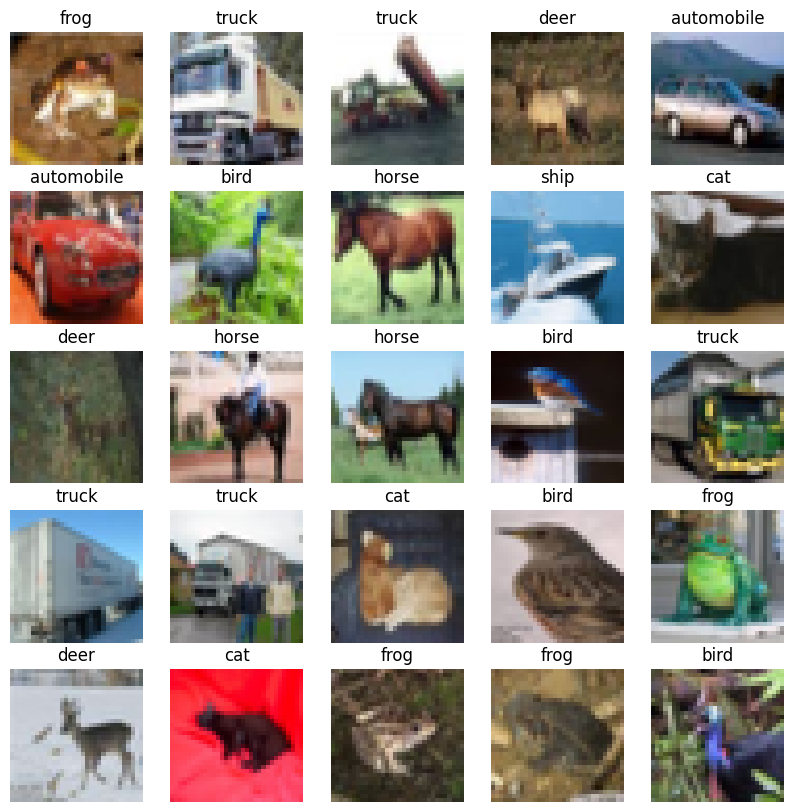

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms

# Define the class names
class_names = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])

# Load the CIFAR-10 dataset and apply transformations
transform = transforms.Compose([transforms.ToTensor()])
cifar_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Define a function to display a grid of images from the dataset
def display_images_grid(images, titles, rows, cols):
    fig, axs = plt.subplots(rows, cols, figsize=(10,10))
    for i in range(rows):
        for j in range(cols):
            axs[i,j].imshow(np.transpose(images[i*cols+j].numpy(), (1, 2, 0)))
            axs[i,j].set_title(class_names[titles[i*cols+j]])
            axs[i,j].axis('off')
    plt.show()

# Display a grid of 25 images from the dataset
images = []
titles = []
for i in range(25):
    image, label = cifar_dataset[i]
    images.append(image)
    titles.append(label)
display_images_grid(images, titles, 5, 5)

'DatasetFetcher' allows fetching and preparing data loaders for the CIFAR-10 dataset using PyTorch's DataLoader class. The class supports data augmentation and normalization. The data augmentation consists of random horizontal flip, random crop, and equalization of the image. The normalization is based on the mean and standard deviation of the training dataset. The code initializes the 'DatasetFetcher' object, adds data augmentation and normalization, and retrieves the training and testing data loaders. The batch_size parameter specifies the number of samples per batch, while size and padding parameters in dataAugmentation method control the size and padding of the random crop.

In [2]:
import torch
import multiprocessing
import torchvision
# import numpy as np
from torch.utils.data import DataLoader

class DatasetFetcher:
    
    def __init__(self, dataset="CIFAR10", batch_size=128):
        # Initialize the class with the specified dataset name and batch size
        print("Initializing fetching %s dataset using torchvision"%(dataset))
        self.datasetObject = torchvision.datasets.__dict__.get(dataset, None)
        if self.datasetObject == None:
            raise Exception("Dataset %s not available in torchvision."%(dataset))
        self.batch_size = batch_size
        self.train_transformers = []
        self.test_transformers = []
        self.workersAvailable = min(multiprocessing.cpu_count(), 14)

    def augmentData(self):
        # Add a transformer that randomly flips the image horizontally during training
        self.train_transformers.append(torchvision.transforms.RandomHorizontalFlip())
        # Add a transformer that randomly crops the image during training
        self.train_transformers.append(torchvision.transforms.RandomCrop(size=32, padding=3))
        # Add a transformer that equalizes the histogram of the image during both training and testing
        self.train_transformers.append(torchvision.transforms.functional.equalize)
        self.test_transformers.append(torchvision.transforms.functional.equalize)

    def __addToTensor(self):
        # Helper function to add a transformer that converts the image to a tensor during both training and testing
        self.train_transformers.append(torchvision.transforms.ToTensor())
        self.test_transformers.append(torchvision.transforms.ToTensor())
        
    def __loadTrainNormalizers(self):
        # Helper function to load the mean and standard deviation of the training dataset
        params = np.load("./trainNormalizedParameters.npz")
        return params['mean'], params['std']

    def addNormalizer(self):
        # Add a transformer that normalizes the image during both training and testing
        self.__addToTensor()
        trainingDataset = self.datasetObject(root="./data", train=True, download=True)
        trainData = trainingDataset.data/255.0
        mean = trainData.mean(axis=(0, 1, 2))
        std = trainData.std(axis=(0, 1, 2))
        np.savez("./trainNormalizedParameters", mean=mean, std=std)
        self.train_transformers.append(torchvision.transforms.Normalize(mean=mean, std=std))
        self.test_transformers.append(torchvision.transforms.Normalize(mean=mean, std=std))
 
        # function to get train and test loaders
    def getLoaders(self):
        # check if train transformers are empty and add 'ToTensor' transformer
        if len(self.train_transformers) == 0:
            self.__addToTensor()
            
        # create training dataset using the 'train_transformers'
        train_dataset = self.datasetObject(
            root="./data", train=True, download=True,
            transform=torchvision.transforms.Compose(self.train_transformers)
        )
        
        # create testing dataset using the 'test_transformers'
        test_dataset = self.datasetObject(
            root="./data", train=False, download=True,
            transform=torchvision.transforms.Compose(self.test_transformers)
        )
        
        # create train loader using the training dataset
        train_loader = DataLoader(
            train_dataset, batch_size=self.batch_size, shuffle=True,
            num_workers=self.workersAvailable
        )
        
        # create test loader using the testing dataset
        test_loader = DataLoader(
            test_dataset, batch_size=self.batch_size, shuffle=False,
            num_workers=self.workersAvailable
        )
        
        return train_loader, test_loader

    # function to get test loader
    def getTestLoader(self):
        # get mean and std dev of train dataset
        mean, std = self.__loadTrainNormalizers()
        
        # append 'ToTensor' and 'Normalize' transformers to 'test_transformers'
        self.test_transformers.append(torchvision.transforms.ToTensor())
        self.test_transformers.append(torchvision.transforms.Normalize(mean=mean, std=std))
        
        # create testing dataset using the updated 'test_transformers'
        test_dataset = self.datasetObject(
            root="./data", train=False, download=True,
            transform=torchvision.transforms.Compose(self.test_transformers)
        )
        
        # create test loader using the testing dataset
        test_loader = DataLoader(
            test_dataset, batch_size=self.batch_size, shuffle=False,
            num_workers=self.workersAvailable
        )
        
        return test_loader

# main code block
if __name__ == "__main__":
    # create an instance of DatasetFetcher class with CIFAR10 dataset and batch size of 128
    df = DatasetFetcher(dataset="CIFAR10", batch_size=128)
    
    # add transformations to the dataset
    df.augmentData()
    df.addNormalizer()
    
    # get train and test loaders using the added transformations
    train_loader, test_loader = df.getLoaders()

   

Initializing fetching CIFAR10 dataset using torchvision
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified



Worked on the basic resnet model from https://github.com/kuangliu/pytorch-cifar/blob/master/models/resnet.py \\
C - Number of channels \\
F - Filter size \\
K - Kernel size \\
P - Pool size \\

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module):

    def __init__(self, in_planes, planes, kernel_size, skip_kernel, stride=1):
        super(BasicBlock, self).__init__()
        # First convolutional layer
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=kernel_size, stride=stride, padding=1, bias=False)
         # Batch normalization layer after the first convolution
        self.bn1 = nn.BatchNorm2d(planes)
        # Second convolutional layer
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=kernel_size, stride=1, padding=1, bias=False)
        # Batch normalization layer after the second convolution
        self.bn2 = nn.BatchNorm2d(planes)

         # Shortcuts are used to add the input to the output of the residual block
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
           # If the input and output dimensions are not the same, use a convolutional layer to match the dimensions
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=skip_kernel, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
      # Apply the first convolutional layer, followed by batch normalization and ReLU activation
        out = F.relu(self.bn1(self.conv1(x)))
        # Apply the second convolutional layer, followed by batch normalization
        out = self.bn2(self.conv2(out))
        # Add the shortcut connection
        out += self.shortcut(x)
         # Apply ReLU activation to the output
        out = F.relu(out)
        return out

class ResNet(nn.Module):

    def __init__(self,N:int, B:list, C:list, F:list, K:list, P:int, num_classes=10):
      # Call the superclass constructor to initialize the nn.Module
        super(ResNet, self).__init__()
        self.in_planes = C[0]
        self.block = BasicBlock
        self.N, self.B, self.C, self.F, self.K, self.P= N, B, C, F, K, P
        self.layers = []          # layers container
        self.S = [2] * N          # strides for layers
        self.S[0] = 1

        # Output Liner layer input dimension
        self.outLayerInSize = C[N-1]*(32//(P*2**(N-1)))*(32//(P*2**(N-1)))

        # Print Model Config
        print("\n\nModel Config: "
            "\n-------------------------------------"
            "\nN (# Layers)\t:",self.N,
            "\nB (# Blocks)\t:",self.B,
            "\nC (# Channels)\t:",C,
            "\nF (Conv Kernel)\t:",F,
            "\nK (Skip Kernel)\t:",K,
            "\nP (Pool Kernel)\t:",P,)

         # Create the first convolutional layer and batch normalization layer
        self.conv1 = nn.Conv2d(3, C[0], kernel_size=F[0], stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(C[0])
        # Create the remaining layers using the specified number of blocks
        for i in range(N): 
            exec("self.layer{} = self._make_layer(self.block, self.C[{}], self.B[{}], self.F[{}], self.K[{}], self.S[{}])"\
                .format(i+1,i,i,i,i,i))
            exec("self.layers.append(self.layer{})".format(i+1))
        # Create the output layer
        self.linear = nn.Linear(self.outLayerInSize, num_classes)
        # Set the path to save the model
        self.path = "./saved_model.pt"
        

    def _make_layer(self, block, planes, num_blocks, kernel_size, skip_kernel, stride):
      # Create a list of strides for each block in the layer
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        # Create each block in the layer
        for stride in strides:
           # Append the block to the list of blocks in the layer
            layers.append(block(self.in_planes, planes, kernel_size, skip_kernel, stride))
            # Update the number of input channels for the next bloc
            self.in_planes = planes
            # Return the layer as a sequential module
        return nn.Sequential(*layers)

    def forward(self, x):
        # Apply the first convolutional layer followed by batch normalization and ReLU activation
        out = F.relu(self.bn1(self.conv1(x)))
        # Apply the remaining layers in the network
        for layer in self.layers:
            out = layer(out)
        # Apply average pooling with kernel size P
        out = F.avg_pool2d(out, self.P)
        # Flatten the output tensor
        out = out.view(out.size(0), -1)
        # Apply the final linear layer to produce the output tensor
        out = self.linear(out)
        # Return the output tensor
        return out

     #Define a function to save the model to disk
    def saveToDisk(self):
      torch.save(self.state_dict(), self.path)

    #Define a function to load the model from disk
    def loadFromDisk(self):
      self.load_state_dict(torch.load(self.path))

def resnet_model():
  B=[3,3,2,3]
  C=[64,128,128,256]
  F=[3,3,3,3]
  K=[1,1,1,1]
  P=4
  N=len(B)

  return ResNet(N, B, C, F, K, P)

In [4]:
import torch
# Set random seed to ensure reproducibility
torch.manual_seed(17)

import numpy as np
from torchsummary import summary
from tqdm import tqdm
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cuda


In [5]:
model = resnet_model()
model = model.to(device)
# Count the number of trainable parameters in the model
trainable_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
# Print the number of trainable parameters
print("Number of trainable parameters:",trainable_parameters)



Model Config: 
-------------------------------------
N (# Layers)	: 4 
B (# Blocks)	: [3, 3, 2, 3] 
C (# Channels)	: [64, 128, 128, 256] 
F (Conv Kernel)	: [3, 3, 3, 3] 
K (Skip Kernel)	: [1, 1, 1, 1] 
P (Pool Kernel)	: 4
Number of trainable parameters: 4935242


To determine the model's best accuracy, we run it for 300 epochs. After that, accuracy becomes almost constant. We specify the following parameters: learning rate, weight decay, and kind of optimizer to be employed (Adam, Adagrad, and AdaDelta), with Adadelta providing the greatest accuracy. A cosine annealing scheduler was used to determine the learning rate for each parameter group.

In [6]:
# Define number of epochs
EPOCHS = 300
# Initialize global best accuracy
globalBestAccuracy = 0.0
# Create empty lists to store training and testing losses and accuracies
trainingLoss = []
testingLoss = []
trainingAccuracy = []
testingAccuracy = []

In [7]:
# Defining Loss Function, Learning Rate, Weight Decay, Optimizer
lossFunction = torch.nn.CrossEntropyLoss(reduction='sum')
learningRate = 0.001
weightDecay = 0.0001

optimizer = torch.optim.Adadelta(model.parameters(), lr=learningRate, weight_decay=weightDecay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, EPOCHS, eta_min=learningRate/10.0)
print(model.eval())
trainable_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total Number of Trainable Parameters : %s"%(trainable_parameters))
if trainable_parameters > 5*(10**6):
    raise Exception("Model parameters are out of range")

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

Now we train and test the model for 300 epochs.

In [8]:
def train(model,loader, optimizer):
    model.train()
    optimizer.zero_grad()
    return model, optimizer

# Training loop
for i in tqdm(range(EPOCHS)):   # Loop over the number of epochs
    for phase in ['train', 'test']:  # Loop over the training and test phases
        if phase == "train": # Set the loader and model mode based on the phase
            loader = train_loader
            model,optimizer= train(model,loader,optimizer)
        else:
            loader = test_loader
            #test
            model.eval()
        runningLoss = 0.0  # Initialize the running loss and corrects
        runningCorrects = 0
        for images, labels in loader:  # Loop over the batches of data
            images = images.to(device)  # Move images and labels to device
            labels = labels.to(device)
            output = model(images)  # Forward pass through the model
            loss = lossFunction(output, labels)  # Compute the loss
            predicted_labels = torch.argmax(output, dim=1)  # Get the predicted labels
            runningLoss += loss.item()  # Update the running loss and corrects
            runningCorrects += torch.sum(predicted_labels == labels).float().item()
            if phase == "train":  # Backward pass and optimization for training phase
                loss.backward()
                optimizer.step()
        epochLoss = runningLoss/len(loader.dataset)  # Compute the epoch loss and accuracy
        epochAccuracy = runningCorrects/len(loader.dataset)
        if phase == "train":  # Update the scheduler and training statistics
            scheduler.step()
            trainingLoss.append(epochLoss)
            trainingAccuracy.append(epochAccuracy)
        else:  # Update the testing statistics and save the model if it is the best so far
            testingLoss.append(epochLoss)
            testingAccuracy.append(epochAccuracy)
            if epochAccuracy > globalBestAccuracy:
                globalBestAccuracy = epochAccuracy
                model.saveToDisk()
    # Print the statistics for the current epoch
    print("Training Loss : %s, Testing Loss : %s, Training Accuracy : %s, Testing Accuracy : %s"\
          %(trainingLoss[-1], testingLoss[-1], trainingAccuracy[-1], testingAccuracy[-1]))


  0%|          | 1/300 [00:17<1:27:42, 17.60s/it]

Training Loss : 1.8662538037109375, Testing Loss : 1.6657401031494141, Training Accuracy : 0.32276, Testing Accuracy : 0.4192


  1%|          | 2/300 [00:28<1:07:07, 13.52s/it]

Training Loss : 1.4163161019897461, Testing Loss : 1.3434539749145509, Training Accuracy : 0.49436, Testing Accuracy : 0.53


  1%|          | 3/300 [00:39<1:00:45, 12.28s/it]

Training Loss : 1.1953927998352052, Testing Loss : 1.1253816698074341, Training Accuracy : 0.57942, Testing Accuracy : 0.6017


  1%|▏         | 4/300 [00:50<58:02, 11.76s/it]  

Training Loss : 1.0620195486450195, Testing Loss : 1.1085166796684265, Training Accuracy : 0.62786, Testing Accuracy : 0.6177


  2%|▏         | 5/300 [01:01<56:54, 11.57s/it]

Training Loss : 0.9433348748779297, Testing Loss : 1.0183473041534423, Training Accuracy : 0.67098, Testing Accuracy : 0.6444


  2%|▏         | 6/300 [01:12<55:24, 11.31s/it]

Training Loss : 0.8505612069702149, Testing Loss : 0.8745778257369995, Training Accuracy : 0.70384, Testing Accuracy : 0.6916


  2%|▏         | 7/300 [01:22<53:45, 11.01s/it]

Training Loss : 0.7830069431304931, Testing Loss : 0.8803440857887268, Training Accuracy : 0.73034, Testing Accuracy : 0.6992


  3%|▎         | 8/300 [01:32<52:41, 10.83s/it]

Training Loss : 0.7407634965515136, Testing Loss : 0.8136616332054138, Training Accuracy : 0.74418, Testing Accuracy : 0.7207


  3%|▎         | 9/300 [01:43<51:59, 10.72s/it]

Training Loss : 0.6886896112060547, Testing Loss : 0.7626980443000794, Training Accuracy : 0.7629, Testing Accuracy : 0.7428


  3%|▎         | 10/300 [01:53<51:27, 10.65s/it]

Training Loss : 0.6548499031829834, Testing Loss : 0.7566085067749023, Training Accuracy : 0.7743, Testing Accuracy : 0.7427


  4%|▎         | 11/300 [02:04<51:04, 10.60s/it]

Training Loss : 0.6044659246063232, Testing Loss : 0.7490909957885742, Training Accuracy : 0.79186, Testing Accuracy : 0.7492


  4%|▍         | 12/300 [02:14<50:34, 10.54s/it]

Training Loss : 0.5784913927459717, Testing Loss : 0.7413905640602112, Training Accuracy : 0.79988, Testing Accuracy : 0.7444


  4%|▍         | 13/300 [02:25<50:12, 10.50s/it]

Training Loss : 0.5557570551300048, Testing Loss : 0.6513759947299957, Training Accuracy : 0.80694, Testing Accuracy : 0.7768


  5%|▍         | 14/300 [02:35<49:54, 10.47s/it]

Training Loss : 0.533730115814209, Testing Loss : 0.6578685610771179, Training Accuracy : 0.81892, Testing Accuracy : 0.7803


  5%|▌         | 15/300 [02:45<49:28, 10.42s/it]

Training Loss : 0.5167227677917481, Testing Loss : 0.7409333316802978, Training Accuracy : 0.82154, Testing Accuracy : 0.759


  5%|▌         | 16/300 [02:56<49:19, 10.42s/it]

Training Loss : 0.49986297058105467, Testing Loss : 0.6063764400482178, Training Accuracy : 0.82718, Testing Accuracy : 0.794


  6%|▌         | 17/300 [03:06<49:08, 10.42s/it]

Training Loss : 0.464722558670044, Testing Loss : 0.6086013252258301, Training Accuracy : 0.83696, Testing Accuracy : 0.795


  6%|▌         | 18/300 [03:17<49:00, 10.43s/it]

Training Loss : 0.4588577568054199, Testing Loss : 0.630759900379181, Training Accuracy : 0.84102, Testing Accuracy : 0.7929


  6%|▋         | 19/300 [03:27<48:46, 10.42s/it]

Training Loss : 0.43867595920562746, Testing Loss : 0.5767605631113052, Training Accuracy : 0.8484, Testing Accuracy : 0.8033


  7%|▋         | 20/300 [03:37<48:25, 10.38s/it]

Training Loss : 0.4151190636444092, Testing Loss : 0.5885890144348145, Training Accuracy : 0.85624, Testing Accuracy : 0.8093


  7%|▋         | 21/300 [03:48<48:09, 10.36s/it]

Training Loss : 0.39684606079101564, Testing Loss : 0.5722597591400147, Training Accuracy : 0.86206, Testing Accuracy : 0.8075


  7%|▋         | 22/300 [03:58<48:04, 10.38s/it]

Training Loss : 0.39264331420898435, Testing Loss : 0.5881906161308289, Training Accuracy : 0.86528, Testing Accuracy : 0.8104


  8%|▊         | 23/300 [04:09<48:04, 10.41s/it]

Training Loss : 0.3941302500915527, Testing Loss : 0.5506311069488525, Training Accuracy : 0.86286, Testing Accuracy : 0.814


  8%|▊         | 24/300 [04:19<48:00, 10.44s/it]

Training Loss : 0.37481734272003175, Testing Loss : 0.5361906149864196, Training Accuracy : 0.87028, Testing Accuracy : 0.8236


  8%|▊         | 25/300 [04:30<47:52, 10.44s/it]

Training Loss : 0.3556720468902588, Testing Loss : 0.5602440091133117, Training Accuracy : 0.8764, Testing Accuracy : 0.8184


  9%|▊         | 26/300 [04:40<47:34, 10.42s/it]

Training Loss : 0.3526160297012329, Testing Loss : 0.5507607588768005, Training Accuracy : 0.87782, Testing Accuracy : 0.8248


  9%|▉         | 27/300 [04:50<47:30, 10.44s/it]

Training Loss : 0.3481510577011108, Testing Loss : 0.5326221696853638, Training Accuracy : 0.87788, Testing Accuracy : 0.8272


  9%|▉         | 28/300 [05:01<47:11, 10.41s/it]

Training Loss : 0.33263987392425537, Testing Loss : 0.5202349229335785, Training Accuracy : 0.88492, Testing Accuracy : 0.8278


 10%|▉         | 29/300 [05:11<47:05, 10.42s/it]

Training Loss : 0.3150354599380493, Testing Loss : 0.561979078578949, Training Accuracy : 0.8911, Testing Accuracy : 0.8234


 10%|█         | 30/300 [05:22<46:51, 10.41s/it]

Training Loss : 0.30630294887542725, Testing Loss : 0.5116453528404236, Training Accuracy : 0.89416, Testing Accuracy : 0.835


 10%|█         | 31/300 [05:32<46:51, 10.45s/it]

Training Loss : 0.3009938233947754, Testing Loss : 0.4980941569328308, Training Accuracy : 0.89578, Testing Accuracy : 0.8376


 11%|█         | 32/300 [05:43<47:18, 10.59s/it]

Training Loss : 0.2758002489280701, Testing Loss : 0.4992936054706574, Training Accuracy : 0.90518, Testing Accuracy : 0.8411


 11%|█         | 33/300 [05:54<47:13, 10.61s/it]

Training Loss : 0.27365508279800416, Testing Loss : 0.4939346125602722, Training Accuracy : 0.90416, Testing Accuracy : 0.8432


 11%|█▏        | 34/300 [06:04<46:51, 10.57s/it]

Training Loss : 0.27176639110565187, Testing Loss : 0.5170616562843323, Training Accuracy : 0.90494, Testing Accuracy : 0.8399


 12%|█▏        | 35/300 [06:15<46:36, 10.55s/it]

Training Loss : 0.2665502941703796, Testing Loss : 0.4936243248462677, Training Accuracy : 0.90794, Testing Accuracy : 0.844


 12%|█▏        | 36/300 [06:25<46:32, 10.58s/it]

Training Loss : 0.2606859973526001, Testing Loss : 0.532832430267334, Training Accuracy : 0.90848, Testing Accuracy : 0.8334


 12%|█▏        | 37/300 [06:36<46:15, 10.55s/it]

Training Loss : 0.2488181916809082, Testing Loss : 0.4877379368782043, Training Accuracy : 0.9129, Testing Accuracy : 0.8498


 13%|█▎        | 38/300 [06:46<45:57, 10.53s/it]

Training Loss : 0.23363650659561158, Testing Loss : 0.4905075375556946, Training Accuracy : 0.91774, Testing Accuracy : 0.8489


 13%|█▎        | 39/300 [06:57<45:51, 10.54s/it]

Training Loss : 0.2316127347755432, Testing Loss : 0.5214739643096924, Training Accuracy : 0.91896, Testing Accuracy : 0.8389


 13%|█▎        | 40/300 [07:07<45:35, 10.52s/it]

Training Loss : 0.23193003374099733, Testing Loss : 0.5164438261032105, Training Accuracy : 0.9198, Testing Accuracy : 0.8412


 14%|█▎        | 41/300 [07:18<45:19, 10.50s/it]

Training Loss : 0.21789987594604493, Testing Loss : 0.49879792213439944, Training Accuracy : 0.92422, Testing Accuracy : 0.8465


 14%|█▍        | 42/300 [07:28<45:03, 10.48s/it]

Training Loss : 0.21987441577911376, Testing Loss : 0.5328145977020263, Training Accuracy : 0.92248, Testing Accuracy : 0.8373


 14%|█▍        | 43/300 [07:39<44:55, 10.49s/it]

Training Loss : 0.22021572925567626, Testing Loss : 0.4674685753941536, Training Accuracy : 0.92152, Testing Accuracy : 0.8532


 15%|█▍        | 44/300 [07:49<44:40, 10.47s/it]

Training Loss : 0.20493081460952758, Testing Loss : 0.5272962008476257, Training Accuracy : 0.92944, Testing Accuracy : 0.8453


 15%|█▌        | 45/300 [08:00<44:27, 10.46s/it]

Training Loss : 0.20416605466842652, Testing Loss : 0.48002300820350646, Training Accuracy : 0.92864, Testing Accuracy : 0.8508


 15%|█▌        | 46/300 [08:10<44:19, 10.47s/it]

Training Loss : 0.19283058209419252, Testing Loss : 0.5134785881996154, Training Accuracy : 0.93178, Testing Accuracy : 0.8507


 16%|█▌        | 47/300 [08:21<44:08, 10.47s/it]

Training Loss : 0.18696690431594848, Testing Loss : 0.5301698679924012, Training Accuracy : 0.9341, Testing Accuracy : 0.845


 16%|█▌        | 48/300 [08:31<43:52, 10.45s/it]

Training Loss : 0.18432499206542968, Testing Loss : 0.49498543958663943, Training Accuracy : 0.9353, Testing Accuracy : 0.857


 16%|█▋        | 49/300 [08:41<43:41, 10.44s/it]

Training Loss : 0.1856429336166382, Testing Loss : 0.5191266826629639, Training Accuracy : 0.93502, Testing Accuracy : 0.8509


 17%|█▋        | 50/300 [08:52<43:41, 10.48s/it]

Training Loss : 0.17398221424102783, Testing Loss : 0.480712212562561, Training Accuracy : 0.9367, Testing Accuracy : 0.8579


 17%|█▋        | 51/300 [09:03<43:38, 10.51s/it]

Training Loss : 0.16915806715011597, Testing Loss : 0.5101039751052856, Training Accuracy : 0.94102, Testing Accuracy : 0.8549


 17%|█▋        | 52/300 [09:13<43:32, 10.53s/it]

Training Loss : 0.16366220435142517, Testing Loss : 0.4807394808769226, Training Accuracy : 0.9421, Testing Accuracy : 0.8616


 18%|█▊        | 53/300 [09:24<43:22, 10.54s/it]

Training Loss : 0.15913182733535766, Testing Loss : 0.509904358959198, Training Accuracy : 0.94368, Testing Accuracy : 0.8604


 18%|█▊        | 54/300 [09:34<43:04, 10.51s/it]

Training Loss : 0.15703868386268616, Testing Loss : 0.5086210745811462, Training Accuracy : 0.94518, Testing Accuracy : 0.8565


 18%|█▊        | 55/300 [09:45<42:58, 10.52s/it]

Training Loss : 0.15701296356201172, Testing Loss : 0.48524989585876466, Training Accuracy : 0.9452, Testing Accuracy : 0.8604


 19%|█▊        | 56/300 [09:55<42:59, 10.57s/it]

Training Loss : 0.1413043305492401, Testing Loss : 0.507053667640686, Training Accuracy : 0.95022, Testing Accuracy : 0.8635


 19%|█▉        | 57/300 [10:06<42:47, 10.57s/it]

Training Loss : 0.152108136510849, Testing Loss : 0.48372424671649933, Training Accuracy : 0.94602, Testing Accuracy : 0.8674


 19%|█▉        | 58/300 [10:16<42:26, 10.52s/it]

Training Loss : 0.1399201856327057, Testing Loss : 0.49622726788520816, Training Accuracy : 0.95058, Testing Accuracy : 0.8667


 20%|█▉        | 59/300 [10:27<42:05, 10.48s/it]

Training Loss : 0.13428523396492004, Testing Loss : 0.5178840578079223, Training Accuracy : 0.95296, Testing Accuracy : 0.865


 20%|██        | 60/300 [10:37<41:46, 10.45s/it]

Training Loss : 0.13674819849014283, Testing Loss : 0.5163258032798768, Training Accuracy : 0.95204, Testing Accuracy : 0.8629


 20%|██        | 61/300 [10:47<41:34, 10.44s/it]

Training Loss : 0.1322390607070923, Testing Loss : 0.5108410436630249, Training Accuracy : 0.95336, Testing Accuracy : 0.8664


 21%|██        | 62/300 [10:58<41:27, 10.45s/it]

Training Loss : 0.131048948135376, Testing Loss : 0.5013119462013245, Training Accuracy : 0.95264, Testing Accuracy : 0.8668


 21%|██        | 63/300 [11:08<41:06, 10.41s/it]

Training Loss : 0.1271512623643875, Testing Loss : 0.49952597024440765, Training Accuracy : 0.95514, Testing Accuracy : 0.8654


 21%|██▏       | 64/300 [11:19<41:06, 10.45s/it]

Training Loss : 0.11345652890205384, Testing Loss : 0.4878487328529358, Training Accuracy : 0.96048, Testing Accuracy : 0.8698


 22%|██▏       | 65/300 [11:29<40:52, 10.44s/it]

Training Loss : 0.11265289281845092, Testing Loss : 0.5247126449584961, Training Accuracy : 0.96088, Testing Accuracy : 0.8662


 22%|██▏       | 66/300 [11:40<40:43, 10.44s/it]

Training Loss : 0.11746718960762025, Testing Loss : 0.5351154520988465, Training Accuracy : 0.95846, Testing Accuracy : 0.8637


 22%|██▏       | 67/300 [11:50<40:34, 10.45s/it]

Training Loss : 0.11214712355613708, Testing Loss : 0.5611689771652222, Training Accuracy : 0.95982, Testing Accuracy : 0.8599


 23%|██▎       | 68/300 [12:00<40:14, 10.41s/it]

Training Loss : 0.1157321691942215, Testing Loss : 0.5091479144334793, Training Accuracy : 0.96014, Testing Accuracy : 0.8669


 23%|██▎       | 69/300 [12:11<40:09, 10.43s/it]

Training Loss : 0.10485703112125397, Testing Loss : 0.4999291008472443, Training Accuracy : 0.96224, Testing Accuracy : 0.8728


 23%|██▎       | 70/300 [12:21<39:53, 10.41s/it]

Training Loss : 0.1002752809381485, Testing Loss : 0.5192036618232727, Training Accuracy : 0.96456, Testing Accuracy : 0.8722


 24%|██▎       | 71/300 [12:32<39:51, 10.44s/it]

Training Loss : 0.10581363327503204, Testing Loss : 0.535554633140564, Training Accuracy : 0.96278, Testing Accuracy : 0.8647


 24%|██▍       | 72/300 [12:42<39:54, 10.50s/it]

Training Loss : 0.10370940030574799, Testing Loss : 0.520601753616333, Training Accuracy : 0.9641, Testing Accuracy : 0.8686


 24%|██▍       | 73/300 [12:53<39:45, 10.51s/it]

Training Loss : 0.10142270682573319, Testing Loss : 0.5529169767379761, Training Accuracy : 0.96294, Testing Accuracy : 0.8621


 25%|██▍       | 74/300 [13:03<39:32, 10.50s/it]

Training Loss : 0.1012654953289032, Testing Loss : 0.5240398093223572, Training Accuracy : 0.96342, Testing Accuracy : 0.8681


 25%|██▌       | 75/300 [13:14<39:22, 10.50s/it]

Training Loss : 0.0929093886089325, Testing Loss : 0.5316607594490051, Training Accuracy : 0.96732, Testing Accuracy : 0.8682


 25%|██▌       | 76/300 [13:24<39:10, 10.49s/it]

Training Loss : 0.09049268567085265, Testing Loss : 0.49683878836631773, Training Accuracy : 0.96762, Testing Accuracy : 0.8712


 26%|██▌       | 77/300 [13:35<39:04, 10.51s/it]

Training Loss : 0.08549810985088348, Testing Loss : 0.5429027696609497, Training Accuracy : 0.96958, Testing Accuracy : 0.8687


 26%|██▌       | 78/300 [13:46<39:06, 10.57s/it]

Training Loss : 0.0893663175201416, Testing Loss : 0.5064703409671784, Training Accuracy : 0.9681, Testing Accuracy : 0.8736


 26%|██▋       | 79/300 [13:56<38:54, 10.56s/it]

Training Loss : 0.08505683374404907, Testing Loss : 0.549904058009386, Training Accuracy : 0.97082, Testing Accuracy : 0.8716


 27%|██▋       | 80/300 [14:07<38:59, 10.63s/it]

Training Loss : 0.08380528077602387, Testing Loss : 0.5236148859262466, Training Accuracy : 0.97046, Testing Accuracy : 0.8745


 27%|██▋       | 81/300 [14:17<38:34, 10.57s/it]

Training Loss : 0.08514337527275086, Testing Loss : 0.5407931794643402, Training Accuracy : 0.97042, Testing Accuracy : 0.8681


 27%|██▋       | 82/300 [14:28<38:16, 10.53s/it]

Training Loss : 0.08436082458019256, Testing Loss : 0.5725540783166886, Training Accuracy : 0.9706, Testing Accuracy : 0.8653


 28%|██▊       | 83/300 [14:38<38:03, 10.52s/it]

Training Loss : 0.08770380759358407, Testing Loss : 0.533921328830719, Training Accuracy : 0.96906, Testing Accuracy : 0.8701


 28%|██▊       | 84/300 [14:49<37:44, 10.49s/it]

Training Loss : 0.08211701847076416, Testing Loss : 0.5374281440734864, Training Accuracy : 0.97084, Testing Accuracy : 0.8706


 28%|██▊       | 85/300 [14:59<37:38, 10.50s/it]

Training Loss : 0.07537575188398361, Testing Loss : 0.5212605007171631, Training Accuracy : 0.97288, Testing Accuracy : 0.8752


 29%|██▊       | 86/300 [15:10<37:30, 10.52s/it]

Training Loss : 0.07255999802827835, Testing Loss : 0.5574333788871765, Training Accuracy : 0.97492, Testing Accuracy : 0.8684


 29%|██▉       | 87/300 [15:20<37:23, 10.54s/it]

Training Loss : 0.07734235044002533, Testing Loss : 0.5443111977100372, Training Accuracy : 0.97234, Testing Accuracy : 0.8732


 29%|██▉       | 88/300 [15:32<37:46, 10.69s/it]

Training Loss : 0.07015193161010742, Testing Loss : 0.5345853957891464, Training Accuracy : 0.9753, Testing Accuracy : 0.8748


 30%|██▉       | 89/300 [15:42<37:18, 10.61s/it]

Training Loss : 0.06686282139539719, Testing Loss : 0.5201376314163209, Training Accuracy : 0.97648, Testing Accuracy : 0.8771


 30%|███       | 90/300 [15:52<37:03, 10.59s/it]

Training Loss : 0.0642404220867157, Testing Loss : 0.5418971031665802, Training Accuracy : 0.97752, Testing Accuracy : 0.8752


 30%|███       | 91/300 [16:03<36:41, 10.53s/it]

Training Loss : 0.06654624984264373, Testing Loss : 0.5663238017559051, Training Accuracy : 0.9769, Testing Accuracy : 0.8682


 31%|███       | 92/300 [16:13<36:33, 10.54s/it]

Training Loss : 0.0666355662894249, Testing Loss : 0.587356153345108, Training Accuracy : 0.97584, Testing Accuracy : 0.8714


 31%|███       | 93/300 [16:24<36:18, 10.52s/it]

Training Loss : 0.06494241427063942, Testing Loss : 0.5598059184074402, Training Accuracy : 0.9774, Testing Accuracy : 0.8731


 31%|███▏      | 94/300 [16:34<36:08, 10.53s/it]

Training Loss : 0.05971387073040008, Testing Loss : 0.5695962330535054, Training Accuracy : 0.97882, Testing Accuracy : 0.8775


 32%|███▏      | 95/300 [16:45<35:51, 10.49s/it]

Training Loss : 0.0667016990494728, Testing Loss : 0.5705787013530731, Training Accuracy : 0.97636, Testing Accuracy : 0.8764


 32%|███▏      | 96/300 [16:55<35:38, 10.48s/it]

Training Loss : 0.06316379163146019, Testing Loss : 0.5546675637811422, Training Accuracy : 0.9776, Testing Accuracy : 0.8716


 32%|███▏      | 97/300 [17:06<35:26, 10.47s/it]

Training Loss : 0.06396604343414307, Testing Loss : 0.5221462406158447, Training Accuracy : 0.97748, Testing Accuracy : 0.8815


 33%|███▎      | 98/300 [17:17<35:47, 10.63s/it]

Training Loss : 0.05750707216978073, Testing Loss : 0.5823400224685669, Training Accuracy : 0.97998, Testing Accuracy : 0.8712


 33%|███▎      | 99/300 [17:27<35:42, 10.66s/it]

Training Loss : 0.06173141025424004, Testing Loss : 0.5936324356555939, Training Accuracy : 0.97824, Testing Accuracy : 0.8722


 33%|███▎      | 100/300 [17:38<35:30, 10.65s/it]

Training Loss : 0.06481414907336235, Testing Loss : 0.5705869001388549, Training Accuracy : 0.97714, Testing Accuracy : 0.8751


 34%|███▎      | 101/300 [17:49<35:07, 10.59s/it]

Training Loss : 0.05772939907312393, Testing Loss : 0.5848600949287415, Training Accuracy : 0.97942, Testing Accuracy : 0.8743


 34%|███▍      | 102/300 [17:59<34:52, 10.57s/it]

Training Loss : 0.05285579008460045, Testing Loss : 0.5710274359464645, Training Accuracy : 0.98162, Testing Accuracy : 0.8784


 34%|███▍      | 103/300 [18:10<34:45, 10.59s/it]

Training Loss : 0.05323540952205658, Testing Loss : 0.5828016855239868, Training Accuracy : 0.98106, Testing Accuracy : 0.8735


 35%|███▍      | 104/300 [18:20<34:32, 10.57s/it]

Training Loss : 0.05644344974398613, Testing Loss : 0.581728347826004, Training Accuracy : 0.98052, Testing Accuracy : 0.8765


 35%|███▌      | 105/300 [18:31<34:16, 10.55s/it]

Training Loss : 0.054057058684825895, Testing Loss : 0.5988112655639648, Training Accuracy : 0.98064, Testing Accuracy : 0.875


 35%|███▌      | 106/300 [18:41<34:02, 10.53s/it]

Training Loss : 0.04787401005983353, Testing Loss : 0.5972558405548334, Training Accuracy : 0.98332, Testing Accuracy : 0.8764


 36%|███▌      | 107/300 [18:52<33:54, 10.54s/it]

Training Loss : 0.05153026680469513, Testing Loss : 0.6146715342521667, Training Accuracy : 0.98206, Testing Accuracy : 0.8717


 36%|███▌      | 108/300 [19:02<33:50, 10.57s/it]

Training Loss : 0.04818371738910675, Testing Loss : 0.5843186022996902, Training Accuracy : 0.98294, Testing Accuracy : 0.8751


 36%|███▋      | 109/300 [19:13<33:36, 10.56s/it]

Training Loss : 0.047492056357860565, Testing Loss : 0.6002495633125305, Training Accuracy : 0.98294, Testing Accuracy : 0.8788


 37%|███▋      | 110/300 [19:24<33:24, 10.55s/it]

Training Loss : 0.04465406561851502, Testing Loss : 0.5744013368606568, Training Accuracy : 0.984, Testing Accuracy : 0.8784


 37%|███▋      | 111/300 [19:34<33:13, 10.55s/it]

Training Loss : 0.04545289334833622, Testing Loss : 0.5999571110725402, Training Accuracy : 0.98394, Testing Accuracy : 0.8746


 37%|███▋      | 112/300 [19:45<32:57, 10.52s/it]

Training Loss : 0.045687686197161674, Testing Loss : 0.6008689532279968, Training Accuracy : 0.98362, Testing Accuracy : 0.8767


 38%|███▊      | 113/300 [19:55<32:48, 10.53s/it]

Training Loss : 0.045299854194521906, Testing Loss : 0.6010772679805756, Training Accuracy : 0.9841, Testing Accuracy : 0.8762


 38%|███▊      | 114/300 [20:06<32:40, 10.54s/it]

Training Loss : 0.04541207080006599, Testing Loss : 0.6218939663410187, Training Accuracy : 0.98454, Testing Accuracy : 0.8734


 38%|███▊      | 115/300 [20:16<32:39, 10.59s/it]

Training Loss : 0.044060411459207534, Testing Loss : 0.5989054594039916, Training Accuracy : 0.98412, Testing Accuracy : 0.8746


 39%|███▊      | 116/300 [20:27<32:35, 10.63s/it]

Training Loss : 0.04405181298553944, Testing Loss : 0.5701116026401519, Training Accuracy : 0.98408, Testing Accuracy : 0.8818


 39%|███▉      | 117/300 [20:38<32:28, 10.65s/it]

Training Loss : 0.038030024650096896, Testing Loss : 0.567917556476593, Training Accuracy : 0.9875, Testing Accuracy : 0.8822


 39%|███▉      | 118/300 [20:48<32:20, 10.66s/it]

Training Loss : 0.03907801564574242, Testing Loss : 0.5630003819465638, Training Accuracy : 0.98588, Testing Accuracy : 0.8809


 40%|███▉      | 119/300 [20:59<32:11, 10.67s/it]

Training Loss : 0.04309384194210172, Testing Loss : 0.596277157497406, Training Accuracy : 0.98492, Testing Accuracy : 0.8779


 40%|████      | 120/300 [21:10<32:05, 10.70s/it]

Training Loss : 0.04105041166096926, Testing Loss : 0.5702588725090026, Training Accuracy : 0.98588, Testing Accuracy : 0.8818


 40%|████      | 121/300 [21:21<32:03, 10.75s/it]

Training Loss : 0.04278110333010554, Testing Loss : 0.5997372554063797, Training Accuracy : 0.98498, Testing Accuracy : 0.8773


 41%|████      | 122/300 [21:31<31:48, 10.72s/it]

Training Loss : 0.038355928227305415, Testing Loss : 0.5642294436454773, Training Accuracy : 0.98632, Testing Accuracy : 0.8832


 41%|████      | 123/300 [21:42<31:29, 10.68s/it]

Training Loss : 0.03753098249614239, Testing Loss : 0.574011700630188, Training Accuracy : 0.9874, Testing Accuracy : 0.8856


 41%|████▏     | 124/300 [21:53<31:16, 10.66s/it]

Training Loss : 0.03624273200333118, Testing Loss : 0.6156723143100739, Training Accuracy : 0.98694, Testing Accuracy : 0.8785


 42%|████▏     | 125/300 [22:03<31:00, 10.63s/it]

Training Loss : 0.037155411803126336, Testing Loss : 0.5720198875427246, Training Accuracy : 0.98658, Testing Accuracy : 0.8861


 42%|████▏     | 126/300 [22:14<30:40, 10.58s/it]

Training Loss : 0.03316698865056038, Testing Loss : 0.5764574975788593, Training Accuracy : 0.98826, Testing Accuracy : 0.8832


 42%|████▏     | 127/300 [22:24<30:19, 10.52s/it]

Training Loss : 0.03504049431145191, Testing Loss : 0.5840635519385338, Training Accuracy : 0.98752, Testing Accuracy : 0.8827


 43%|████▎     | 128/300 [22:35<30:09, 10.52s/it]

Training Loss : 0.028833151485025882, Testing Loss : 0.5823344124317169, Training Accuracy : 0.99032, Testing Accuracy : 0.8876


 43%|████▎     | 129/300 [22:45<29:58, 10.52s/it]

Training Loss : 0.03312777439713478, Testing Loss : 0.5974829162120819, Training Accuracy : 0.98818, Testing Accuracy : 0.8823


 43%|████▎     | 130/300 [22:56<29:46, 10.51s/it]

Training Loss : 0.03224595711439848, Testing Loss : 0.6258650175094604, Training Accuracy : 0.98848, Testing Accuracy : 0.8815


 44%|████▎     | 131/300 [23:06<29:41, 10.54s/it]

Training Loss : 0.03168098992586136, Testing Loss : 0.5809717549800872, Training Accuracy : 0.9891, Testing Accuracy : 0.8827


 44%|████▍     | 132/300 [23:17<29:36, 10.57s/it]

Training Loss : 0.03130867347568274, Testing Loss : 0.5908160040855408, Training Accuracy : 0.98888, Testing Accuracy : 0.8813


 44%|████▍     | 133/300 [23:27<29:13, 10.50s/it]

Training Loss : 0.031032696498185398, Testing Loss : 0.5986586268424988, Training Accuracy : 0.98908, Testing Accuracy : 0.8836


 45%|████▍     | 134/300 [23:38<29:06, 10.52s/it]

Training Loss : 0.027209328158944845, Testing Loss : 0.604891473865509, Training Accuracy : 0.99026, Testing Accuracy : 0.8867


 45%|████▌     | 135/300 [23:48<28:51, 10.49s/it]

Training Loss : 0.026461671870201826, Testing Loss : 0.5881760382175446, Training Accuracy : 0.9908, Testing Accuracy : 0.8872


 45%|████▌     | 136/300 [23:59<28:46, 10.53s/it]

Training Loss : 0.024953955941200257, Testing Loss : 0.5829440707683563, Training Accuracy : 0.99122, Testing Accuracy : 0.8892


 46%|████▌     | 137/300 [24:09<28:29, 10.49s/it]

Training Loss : 0.025432518008202315, Testing Loss : 0.5909916999816894, Training Accuracy : 0.99076, Testing Accuracy : 0.8865


 46%|████▌     | 138/300 [24:20<28:17, 10.48s/it]

Training Loss : 0.025786162701547145, Testing Loss : 0.603816944885254, Training Accuracy : 0.99066, Testing Accuracy : 0.8887


 46%|████▋     | 139/300 [24:30<28:05, 10.47s/it]

Training Loss : 0.029860442261099816, Testing Loss : 0.6289970924377442, Training Accuracy : 0.9893, Testing Accuracy : 0.8827


 47%|████▋     | 140/300 [24:40<27:54, 10.46s/it]

Training Loss : 0.034055648575425146, Testing Loss : 0.6106108581066132, Training Accuracy : 0.98798, Testing Accuracy : 0.8839


 47%|████▋     | 141/300 [24:51<27:46, 10.48s/it]

Training Loss : 0.027016201850175857, Testing Loss : 0.6011963054656982, Training Accuracy : 0.99064, Testing Accuracy : 0.8843


 47%|████▋     | 142/300 [25:01<27:33, 10.47s/it]

Training Loss : 0.02523105200499296, Testing Loss : 0.6143964597702026, Training Accuracy : 0.99114, Testing Accuracy : 0.8816


 48%|████▊     | 143/300 [25:12<27:25, 10.48s/it]

Training Loss : 0.02406347538292408, Testing Loss : 0.5682060471534729, Training Accuracy : 0.99136, Testing Accuracy : 0.8881


 48%|████▊     | 144/300 [25:22<27:15, 10.49s/it]

Training Loss : 0.025056199030429126, Testing Loss : 0.5979902398109436, Training Accuracy : 0.99104, Testing Accuracy : 0.8892


 48%|████▊     | 145/300 [25:33<27:03, 10.47s/it]

Training Loss : 0.023849276245087384, Testing Loss : 0.579331153011322, Training Accuracy : 0.99204, Testing Accuracy : 0.8893


 49%|████▊     | 146/300 [25:43<26:53, 10.48s/it]

Training Loss : 0.02229028410613537, Testing Loss : 0.6045543453216553, Training Accuracy : 0.99198, Testing Accuracy : 0.8871


 49%|████▉     | 147/300 [25:54<26:36, 10.43s/it]

Training Loss : 0.020932507846355437, Testing Loss : 0.6008876209974289, Training Accuracy : 0.9928, Testing Accuracy : 0.8891


 49%|████▉     | 148/300 [26:04<26:34, 10.49s/it]

Training Loss : 0.01927768662199378, Testing Loss : 0.6500640467643738, Training Accuracy : 0.99338, Testing Accuracy : 0.8862


 50%|████▉     | 149/300 [26:15<26:23, 10.49s/it]

Training Loss : 0.022024390799701213, Testing Loss : 0.652540012550354, Training Accuracy : 0.99274, Testing Accuracy : 0.8849


 50%|█████     | 150/300 [26:25<26:15, 10.50s/it]

Training Loss : 0.02615245407193899, Testing Loss : 0.6376911922454834, Training Accuracy : 0.99064, Testing Accuracy : 0.8819


 50%|█████     | 151/300 [26:36<26:05, 10.51s/it]

Training Loss : 0.023567324286848306, Testing Loss : 0.6329512134552002, Training Accuracy : 0.99184, Testing Accuracy : 0.8869


 51%|█████     | 152/300 [26:46<25:58, 10.53s/it]

Training Loss : 0.020515001370310783, Testing Loss : 0.6135947590827942, Training Accuracy : 0.99252, Testing Accuracy : 0.8867


 51%|█████     | 153/300 [26:57<25:44, 10.51s/it]

Training Loss : 0.020260299117416142, Testing Loss : 0.6238497660636901, Training Accuracy : 0.99292, Testing Accuracy : 0.8886


 51%|█████▏    | 154/300 [27:07<25:33, 10.50s/it]

Training Loss : 0.020248091189265252, Testing Loss : 0.6398550621032715, Training Accuracy : 0.99306, Testing Accuracy : 0.8864


 52%|█████▏    | 155/300 [27:18<25:21, 10.49s/it]

Training Loss : 0.020945707331001758, Testing Loss : 0.6002294457435607, Training Accuracy : 0.99282, Testing Accuracy : 0.892


 52%|█████▏    | 156/300 [27:28<25:08, 10.47s/it]

Training Loss : 0.01676457899928093, Testing Loss : 0.6106654238700867, Training Accuracy : 0.9943, Testing Accuracy : 0.8899


 52%|█████▏    | 157/300 [27:39<24:57, 10.47s/it]

Training Loss : 0.02111901039622724, Testing Loss : 0.6275574655532837, Training Accuracy : 0.99262, Testing Accuracy : 0.8868


 53%|█████▎    | 158/300 [27:49<24:48, 10.48s/it]

Training Loss : 0.017255943360328676, Testing Loss : 0.6338206220626831, Training Accuracy : 0.99416, Testing Accuracy : 0.8888


 53%|█████▎    | 159/300 [28:00<24:38, 10.49s/it]

Training Loss : 0.016530705658644437, Testing Loss : 0.6296038003921509, Training Accuracy : 0.9946, Testing Accuracy : 0.8888


 53%|█████▎    | 160/300 [28:10<24:27, 10.48s/it]

Training Loss : 0.016891803473830222, Testing Loss : 0.6193366832733155, Training Accuracy : 0.9942, Testing Accuracy : 0.8916


 54%|█████▎    | 161/300 [28:21<24:17, 10.49s/it]

Training Loss : 0.015407432761192321, Testing Loss : 0.5931326333999634, Training Accuracy : 0.99464, Testing Accuracy : 0.8921


 54%|█████▍    | 162/300 [28:31<24:07, 10.49s/it]

Training Loss : 0.014502666859179735, Testing Loss : 0.6023535122871398, Training Accuracy : 0.99536, Testing Accuracy : 0.8964


 54%|█████▍    | 163/300 [28:42<23:50, 10.44s/it]

Training Loss : 0.014682399601116777, Testing Loss : 0.6223998479366303, Training Accuracy : 0.99492, Testing Accuracy : 0.8907


 55%|█████▍    | 164/300 [28:52<23:41, 10.45s/it]

Training Loss : 0.013820224630311132, Testing Loss : 0.6100781467914581, Training Accuracy : 0.99528, Testing Accuracy : 0.8967


 55%|█████▌    | 165/300 [29:03<23:37, 10.50s/it]

Training Loss : 0.01878070421397686, Testing Loss : 0.6567750557899475, Training Accuracy : 0.9938, Testing Accuracy : 0.8826


 55%|█████▌    | 166/300 [29:13<23:26, 10.49s/it]

Training Loss : 0.021672504981458188, Testing Loss : 0.6448265542984009, Training Accuracy : 0.99256, Testing Accuracy : 0.8866


 56%|█████▌    | 167/300 [29:24<23:21, 10.54s/it]

Training Loss : 0.019226397873423992, Testing Loss : 0.6406645893573761, Training Accuracy : 0.99306, Testing Accuracy : 0.8864


 56%|█████▌    | 168/300 [29:34<23:12, 10.55s/it]

Training Loss : 0.015993525885939597, Testing Loss : 0.6166260993003845, Training Accuracy : 0.99414, Testing Accuracy : 0.8892


 56%|█████▋    | 169/300 [29:45<22:52, 10.47s/it]

Training Loss : 0.013723779138848185, Testing Loss : 0.6306716454982757, Training Accuracy : 0.9955, Testing Accuracy : 0.889


 57%|█████▋    | 170/300 [29:55<22:40, 10.47s/it]

Training Loss : 0.012490943939685821, Testing Loss : 0.619845179271698, Training Accuracy : 0.99578, Testing Accuracy : 0.891


 57%|█████▋    | 171/300 [30:06<22:36, 10.51s/it]

Training Loss : 0.012892450593709946, Testing Loss : 0.6546307666778565, Training Accuracy : 0.99542, Testing Accuracy : 0.8892


 57%|█████▋    | 172/300 [30:16<22:26, 10.52s/it]

Training Loss : 0.015215589883774519, Testing Loss : 0.6246884172916413, Training Accuracy : 0.99502, Testing Accuracy : 0.8935


 58%|█████▊    | 173/300 [30:27<22:13, 10.50s/it]

Training Loss : 0.01422805865071714, Testing Loss : 0.6413348546028137, Training Accuracy : 0.99496, Testing Accuracy : 0.8889


 58%|█████▊    | 174/300 [30:37<21:53, 10.43s/it]

Training Loss : 0.012906617007777095, Testing Loss : 0.6440272665977478, Training Accuracy : 0.99522, Testing Accuracy : 0.8921


 58%|█████▊    | 175/300 [30:47<21:44, 10.44s/it]

Training Loss : 0.014553312672227621, Testing Loss : 0.6602543483734131, Training Accuracy : 0.99544, Testing Accuracy : 0.8865


 59%|█████▊    | 176/300 [30:58<21:36, 10.46s/it]

Training Loss : 0.014457258522473275, Testing Loss : 0.635892179107666, Training Accuracy : 0.99512, Testing Accuracy : 0.89


 59%|█████▉    | 177/300 [31:08<21:26, 10.46s/it]

Training Loss : 0.015101914367973805, Testing Loss : 0.6321976152420044, Training Accuracy : 0.99484, Testing Accuracy : 0.8895


 59%|█████▉    | 178/300 [31:19<21:17, 10.47s/it]

Training Loss : 0.012149103264212608, Testing Loss : 0.6444782021045685, Training Accuracy : 0.9959, Testing Accuracy : 0.8894


 60%|█████▉    | 179/300 [31:29<21:11, 10.51s/it]

Training Loss : 0.014512172136828304, Testing Loss : 0.6135335550308227, Training Accuracy : 0.99504, Testing Accuracy : 0.8927


 60%|██████    | 180/300 [31:40<21:00, 10.51s/it]

Training Loss : 0.01011477273568511, Testing Loss : 0.6082956804275512, Training Accuracy : 0.99656, Testing Accuracy : 0.8957


 60%|██████    | 181/300 [31:51<20:56, 10.56s/it]

Training Loss : 0.008188617612980306, Testing Loss : 0.6032470183372498, Training Accuracy : 0.9971, Testing Accuracy : 0.8975


 61%|██████    | 182/300 [32:02<21:02, 10.70s/it]

Training Loss : 0.008988374745957553, Testing Loss : 0.6313004870414733, Training Accuracy : 0.99694, Testing Accuracy : 0.8973


 61%|██████    | 183/300 [32:13<21:03, 10.80s/it]

Training Loss : 0.009742686619143933, Testing Loss : 0.6566420909881592, Training Accuracy : 0.99676, Testing Accuracy : 0.89


 61%|██████▏   | 184/300 [32:23<20:51, 10.79s/it]

Training Loss : 0.012043705990687013, Testing Loss : 0.6275214273929596, Training Accuracy : 0.99586, Testing Accuracy : 0.8945


 62%|██████▏   | 185/300 [32:34<20:26, 10.67s/it]

Training Loss : 0.010921484531573952, Testing Loss : 0.6566480933189393, Training Accuracy : 0.99636, Testing Accuracy : 0.895


 62%|██████▏   | 186/300 [32:44<20:09, 10.61s/it]

Training Loss : 0.011437065153829754, Testing Loss : 0.6616378809928894, Training Accuracy : 0.99598, Testing Accuracy : 0.8912


 62%|██████▏   | 187/300 [32:55<19:54, 10.57s/it]

Training Loss : 0.010788882171418518, Testing Loss : 0.6651254900932312, Training Accuracy : 0.99634, Testing Accuracy : 0.8906


 63%|██████▎   | 188/300 [33:05<19:39, 10.53s/it]

Training Loss : 0.011311472757905722, Testing Loss : 0.6328971901893615, Training Accuracy : 0.99622, Testing Accuracy : 0.8945


 63%|██████▎   | 189/300 [33:16<19:26, 10.51s/it]

Training Loss : 0.009266173661909998, Testing Loss : 0.6575726703643798, Training Accuracy : 0.99702, Testing Accuracy : 0.8922


 63%|██████▎   | 190/300 [33:26<19:16, 10.52s/it]

Training Loss : 0.009757639146931469, Testing Loss : 0.6792892092466354, Training Accuracy : 0.99642, Testing Accuracy : 0.8911


 64%|██████▎   | 191/300 [33:37<19:02, 10.48s/it]

Training Loss : 0.009278816643580795, Testing Loss : 0.6422575443267823, Training Accuracy : 0.9966, Testing Accuracy : 0.8935


 64%|██████▍   | 192/300 [33:47<18:52, 10.48s/it]

Training Loss : 0.007584355756305158, Testing Loss : 0.626894696521759, Training Accuracy : 0.99776, Testing Accuracy : 0.8965


 64%|██████▍   | 193/300 [33:58<18:47, 10.53s/it]

Training Loss : 0.007573820104580372, Testing Loss : 0.6506578840255738, Training Accuracy : 0.99784, Testing Accuracy : 0.8928


 65%|██████▍   | 194/300 [34:08<18:34, 10.51s/it]

Training Loss : 0.008764086354970932, Testing Loss : 0.6813692679405212, Training Accuracy : 0.9973, Testing Accuracy : 0.8929


 65%|██████▌   | 195/300 [34:19<18:22, 10.50s/it]

Training Loss : 0.010144842083565891, Testing Loss : 0.6600033898353577, Training Accuracy : 0.99648, Testing Accuracy : 0.8925


 65%|██████▌   | 196/300 [34:29<18:12, 10.51s/it]

Training Loss : 0.008818955814661458, Testing Loss : 0.661239198589325, Training Accuracy : 0.9968, Testing Accuracy : 0.8944


 66%|██████▌   | 197/300 [34:40<18:02, 10.51s/it]

Training Loss : 0.008069485589116812, Testing Loss : 0.625630597114563, Training Accuracy : 0.9972, Testing Accuracy : 0.8999


 66%|██████▌   | 198/300 [34:50<17:48, 10.48s/it]

Training Loss : 0.006817174802944064, Testing Loss : 0.6602940146446228, Training Accuracy : 0.99778, Testing Accuracy : 0.8942


 66%|██████▋   | 199/300 [35:01<17:34, 10.44s/it]

Training Loss : 0.00760438196009025, Testing Loss : 0.6501875285148621, Training Accuracy : 0.99716, Testing Accuracy : 0.8977


 67%|██████▋   | 200/300 [35:11<17:23, 10.44s/it]

Training Loss : 0.006586933319568634, Testing Loss : 0.6502922933578491, Training Accuracy : 0.99772, Testing Accuracy : 0.8939


 67%|██████▋   | 201/300 [35:22<17:17, 10.48s/it]

Training Loss : 0.007161898260768503, Testing Loss : 0.6448899015903473, Training Accuracy : 0.99744, Testing Accuracy : 0.8976


 67%|██████▋   | 202/300 [35:32<17:10, 10.51s/it]

Training Loss : 0.006550885494835674, Testing Loss : 0.6779857492446899, Training Accuracy : 0.99786, Testing Accuracy : 0.8907


 68%|██████▊   | 203/300 [35:43<16:57, 10.49s/it]

Training Loss : 0.008064492619428784, Testing Loss : 0.6690284469604492, Training Accuracy : 0.99724, Testing Accuracy : 0.8944


 68%|██████▊   | 204/300 [35:53<16:46, 10.48s/it]

Training Loss : 0.007406370863188058, Testing Loss : 0.67841921377182, Training Accuracy : 0.99754, Testing Accuracy : 0.8957


 68%|██████▊   | 205/300 [36:03<16:33, 10.46s/it]

Training Loss : 0.006629788223439828, Testing Loss : 0.6734197564601898, Training Accuracy : 0.99778, Testing Accuracy : 0.8923


 69%|██████▊   | 206/300 [36:14<16:22, 10.45s/it]

Training Loss : 0.007803896881788969, Testing Loss : 0.6583141722679138, Training Accuracy : 0.99748, Testing Accuracy : 0.8952


 69%|██████▉   | 207/300 [36:24<16:11, 10.45s/it]

Training Loss : 0.007613194861002266, Testing Loss : 0.660343299484253, Training Accuracy : 0.99772, Testing Accuracy : 0.8932


 69%|██████▉   | 208/300 [36:35<16:04, 10.48s/it]

Training Loss : 0.006774169429447502, Testing Loss : 0.6361275701522827, Training Accuracy : 0.99764, Testing Accuracy : 0.8969


 70%|██████▉   | 209/300 [36:45<15:56, 10.51s/it]

Training Loss : 0.005806089605968446, Testing Loss : 0.656416617488861, Training Accuracy : 0.99806, Testing Accuracy : 0.8935


 70%|███████   | 210/300 [36:56<15:50, 10.56s/it]

Training Loss : 0.006127311423411593, Testing Loss : 0.6489252112865448, Training Accuracy : 0.99798, Testing Accuracy : 0.8975


 70%|███████   | 211/300 [37:07<15:40, 10.57s/it]

Training Loss : 0.006176797319604084, Testing Loss : 0.6697911788940429, Training Accuracy : 0.99804, Testing Accuracy : 0.8959


 71%|███████   | 212/300 [37:17<15:30, 10.57s/it]

Training Loss : 0.005402199484426528, Testing Loss : 0.6543458471298218, Training Accuracy : 0.99806, Testing Accuracy : 0.8955


 71%|███████   | 213/300 [37:28<15:15, 10.53s/it]

Training Loss : 0.005115267452853732, Testing Loss : 0.6543757422685623, Training Accuracy : 0.99838, Testing Accuracy : 0.8978


 71%|███████▏  | 214/300 [37:38<15:08, 10.56s/it]

Training Loss : 0.0049853259032778445, Testing Loss : 0.6552601687431335, Training Accuracy : 0.99838, Testing Accuracy : 0.8951


 72%|███████▏  | 215/300 [37:49<15:00, 10.59s/it]

Training Loss : 0.0056544916190579535, Testing Loss : 0.6681381235122681, Training Accuracy : 0.99818, Testing Accuracy : 0.8965


 72%|███████▏  | 216/300 [38:00<14:49, 10.59s/it]

Training Loss : 0.004741907258629799, Testing Loss : 0.6579570130348206, Training Accuracy : 0.99844, Testing Accuracy : 0.8945


 72%|███████▏  | 217/300 [38:10<14:38, 10.58s/it]

Training Loss : 0.004568434318173676, Testing Loss : 0.6519394728660584, Training Accuracy : 0.99856, Testing Accuracy : 0.8976


 73%|███████▎  | 218/300 [38:21<14:27, 10.58s/it]

Training Loss : 0.0048828585605043915, Testing Loss : 0.657586936044693, Training Accuracy : 0.9983, Testing Accuracy : 0.8968


 73%|███████▎  | 219/300 [38:31<14:16, 10.58s/it]

Training Loss : 0.004824030519733205, Testing Loss : 0.667265703177452, Training Accuracy : 0.99824, Testing Accuracy : 0.8993


 73%|███████▎  | 220/300 [38:42<14:09, 10.62s/it]

Training Loss : 0.003552907424522564, Testing Loss : 0.6360545986175538, Training Accuracy : 0.99878, Testing Accuracy : 0.9


 74%|███████▎  | 221/300 [38:53<14:03, 10.68s/it]

Training Loss : 0.0038246838375832885, Testing Loss : 0.6680793910980225, Training Accuracy : 0.99882, Testing Accuracy : 0.8981


 74%|███████▍  | 222/300 [39:03<13:47, 10.61s/it]

Training Loss : 0.003386016986896284, Testing Loss : 0.673390843629837, Training Accuracy : 0.99902, Testing Accuracy : 0.8994


 74%|███████▍  | 223/300 [39:14<13:34, 10.57s/it]

Training Loss : 0.004201939012492076, Testing Loss : 0.6637900248527527, Training Accuracy : 0.99886, Testing Accuracy : 0.8984


 75%|███████▍  | 224/300 [39:24<13:22, 10.56s/it]

Training Loss : 0.0046594112153258175, Testing Loss : 0.6872949007034301, Training Accuracy : 0.99842, Testing Accuracy : 0.8969


 75%|███████▌  | 225/300 [39:35<13:10, 10.54s/it]

Training Loss : 0.004279941196059808, Testing Loss : 0.6513703169584274, Training Accuracy : 0.99854, Testing Accuracy : 0.8996


 75%|███████▌  | 226/300 [39:45<12:59, 10.53s/it]

Training Loss : 0.0032505606409860776, Testing Loss : 0.6749204167842865, Training Accuracy : 0.99912, Testing Accuracy : 0.899


 76%|███████▌  | 227/300 [39:56<12:47, 10.51s/it]

Training Loss : 0.002418757597794756, Testing Loss : 0.6606180560111999, Training Accuracy : 0.99934, Testing Accuracy : 0.9013


 76%|███████▌  | 228/300 [40:06<12:39, 10.54s/it]

Training Loss : 0.0031706657579541205, Testing Loss : 0.6817866356372834, Training Accuracy : 0.99902, Testing Accuracy : 0.8962


 76%|███████▋  | 229/300 [40:17<12:28, 10.54s/it]

Training Loss : 0.003706348287691362, Testing Loss : 0.6760534650802612, Training Accuracy : 0.99894, Testing Accuracy : 0.8993


 77%|███████▋  | 230/300 [40:27<12:17, 10.53s/it]

Training Loss : 0.004688412194969132, Testing Loss : 0.7059957735061646, Training Accuracy : 0.99856, Testing Accuracy : 0.8943


 77%|███████▋  | 231/300 [40:38<12:07, 10.55s/it]

Training Loss : 0.003638078278012108, Testing Loss : 0.6768026761054993, Training Accuracy : 0.99874, Testing Accuracy : 0.8975


 77%|███████▋  | 232/300 [40:49<11:59, 10.58s/it]

Training Loss : 0.003458729990660213, Testing Loss : 0.6703571002006531, Training Accuracy : 0.99886, Testing Accuracy : 0.9005


 78%|███████▊  | 233/300 [40:59<11:48, 10.58s/it]

Training Loss : 0.0024293451039423234, Testing Loss : 0.6651946890354157, Training Accuracy : 0.99922, Testing Accuracy : 0.8996


 78%|███████▊  | 234/300 [41:10<11:34, 10.53s/it]

Training Loss : 0.002449294006978162, Testing Loss : 0.6714849188804627, Training Accuracy : 0.9993, Testing Accuracy : 0.9


 78%|███████▊  | 235/300 [41:20<11:22, 10.50s/it]

Training Loss : 0.0027389562970167028, Testing Loss : 0.678888131800294, Training Accuracy : 0.99914, Testing Accuracy : 0.8989


 79%|███████▊  | 236/300 [41:31<11:11, 10.49s/it]

Training Loss : 0.0023668180670402945, Testing Loss : 0.6804539315223694, Training Accuracy : 0.99926, Testing Accuracy : 0.8994


 79%|███████▉  | 237/300 [41:41<11:00, 10.48s/it]

Training Loss : 0.002759460698873736, Testing Loss : 0.6966994882106781, Training Accuracy : 0.9991, Testing Accuracy : 0.8994


 79%|███████▉  | 238/300 [41:52<10:50, 10.50s/it]

Training Loss : 0.00282297160748858, Testing Loss : 0.6859370210647583, Training Accuracy : 0.99896, Testing Accuracy : 0.8969


 80%|███████▉  | 239/300 [42:02<10:42, 10.53s/it]

Training Loss : 0.00278760429170914, Testing Loss : 0.6729844278335572, Training Accuracy : 0.99898, Testing Accuracy : 0.9025


 80%|████████  | 240/300 [42:13<10:32, 10.55s/it]

Training Loss : 0.0025117569926031867, Testing Loss : 0.6919893527507782, Training Accuracy : 0.99928, Testing Accuracy : 0.8981


 80%|████████  | 241/300 [42:23<10:19, 10.50s/it]

Training Loss : 0.001859639975700993, Testing Loss : 0.6766670226871967, Training Accuracy : 0.99944, Testing Accuracy : 0.9028


 81%|████████  | 242/300 [42:34<10:09, 10.50s/it]

Training Loss : 0.0017697121662274002, Testing Loss : 0.7008198610305786, Training Accuracy : 0.99944, Testing Accuracy : 0.9015


 81%|████████  | 243/300 [42:44<09:58, 10.51s/it]

Training Loss : 0.0018540860930085182, Testing Loss : 0.6790270782470703, Training Accuracy : 0.99938, Testing Accuracy : 0.9018


 81%|████████▏ | 244/300 [42:55<09:50, 10.54s/it]

Training Loss : 0.002570765457919333, Testing Loss : 0.6899656699180603, Training Accuracy : 0.9992, Testing Accuracy : 0.9022


 82%|████████▏ | 245/300 [43:05<09:38, 10.52s/it]

Training Loss : 0.002212760131149553, Testing Loss : 0.6867506949424743, Training Accuracy : 0.99946, Testing Accuracy : 0.8995


 82%|████████▏ | 246/300 [43:16<09:30, 10.56s/it]

Training Loss : 0.002673421053593047, Testing Loss : 0.6990853207588196, Training Accuracy : 0.99914, Testing Accuracy : 0.9034


 82%|████████▏ | 247/300 [43:26<09:19, 10.56s/it]

Training Loss : 0.002634861858700169, Testing Loss : 0.6834691866874695, Training Accuracy : 0.99916, Testing Accuracy : 0.9023


 83%|████████▎ | 248/300 [43:37<09:07, 10.53s/it]

Training Loss : 0.0017124528421461583, Testing Loss : 0.6770087198257446, Training Accuracy : 0.99956, Testing Accuracy : 0.9051


 83%|████████▎ | 249/300 [43:48<08:57, 10.55s/it]

Training Loss : 0.001712159368712455, Testing Loss : 0.6816388083457947, Training Accuracy : 0.9995, Testing Accuracy : 0.9004


 83%|████████▎ | 250/300 [43:58<08:46, 10.54s/it]

Training Loss : 0.0022068159863865002, Testing Loss : 0.6980402442932129, Training Accuracy : 0.99926, Testing Accuracy : 0.9035


 84%|████████▎ | 251/300 [44:08<08:34, 10.50s/it]

Training Loss : 0.0016387182528781704, Testing Loss : 0.6804735988616943, Training Accuracy : 0.99958, Testing Accuracy : 0.9016


 84%|████████▍ | 252/300 [44:19<08:24, 10.51s/it]

Training Loss : 0.0013892968147876672, Testing Loss : 0.6848071231842041, Training Accuracy : 0.99956, Testing Accuracy : 0.9022


 84%|████████▍ | 253/300 [44:30<08:14, 10.53s/it]

Training Loss : 0.0012263138919090851, Testing Loss : 0.675020612001419, Training Accuracy : 0.99966, Testing Accuracy : 0.902


 85%|████████▍ | 254/300 [44:40<08:04, 10.53s/it]

Training Loss : 0.0011813543431833386, Testing Loss : 0.6834567112922668, Training Accuracy : 0.99958, Testing Accuracy : 0.9047


 85%|████████▌ | 255/300 [44:50<07:51, 10.48s/it]

Training Loss : 0.001342132056520786, Testing Loss : 0.7111094902992249, Training Accuracy : 0.99966, Testing Accuracy : 0.9011


 85%|████████▌ | 256/300 [45:01<07:43, 10.53s/it]

Training Loss : 0.0010299395026522689, Testing Loss : 0.6894614042282105, Training Accuracy : 0.9998, Testing Accuracy : 0.9026


 86%|████████▌ | 257/300 [45:12<07:31, 10.50s/it]

Training Loss : 0.0017347887920239008, Testing Loss : 0.6987519804000855, Training Accuracy : 0.99942, Testing Accuracy : 0.9025


 86%|████████▌ | 258/300 [45:22<07:21, 10.52s/it]

Training Loss : 0.001798889086015988, Testing Loss : 0.679735498714447, Training Accuracy : 0.99934, Testing Accuracy : 0.905


 86%|████████▋ | 259/300 [45:33<07:12, 10.54s/it]

Training Loss : 0.0015845150479767472, Testing Loss : 0.6967005704879761, Training Accuracy : 0.99962, Testing Accuracy : 0.9037


 87%|████████▋ | 260/300 [45:43<07:01, 10.54s/it]

Training Loss : 0.0011104721953812987, Testing Loss : 0.7019404251098633, Training Accuracy : 0.99968, Testing Accuracy : 0.9008


 87%|████████▋ | 261/300 [45:54<06:52, 10.57s/it]

Training Loss : 0.0014745017347671092, Testing Loss : 0.7028266550064087, Training Accuracy : 0.99958, Testing Accuracy : 0.9031


 87%|████████▋ | 262/300 [46:04<06:39, 10.51s/it]

Training Loss : 0.0012436598954652437, Testing Loss : 0.7040080949306488, Training Accuracy : 0.99954, Testing Accuracy : 0.9001


 88%|████████▊ | 263/300 [46:15<06:28, 10.50s/it]

Training Loss : 0.0013951508415164426, Testing Loss : 0.7073293671607971, Training Accuracy : 0.99962, Testing Accuracy : 0.9013


 88%|████████▊ | 264/300 [46:25<06:18, 10.52s/it]

Training Loss : 0.001446576361184707, Testing Loss : 0.7026135570049286, Training Accuracy : 0.9996, Testing Accuracy : 0.9011


 88%|████████▊ | 265/300 [46:36<06:08, 10.52s/it]

Training Loss : 0.0009085878424730618, Testing Loss : 0.6825417836666107, Training Accuracy : 0.9997, Testing Accuracy : 0.9039


 89%|████████▊ | 266/300 [46:46<05:56, 10.49s/it]

Training Loss : 0.000939852454905631, Testing Loss : 0.6837749890327454, Training Accuracy : 0.99972, Testing Accuracy : 0.9043


 89%|████████▉ | 267/300 [46:57<05:46, 10.51s/it]

Training Loss : 0.0009029631723929196, Testing Loss : 0.6874745220184326, Training Accuracy : 0.99974, Testing Accuracy : 0.902


 89%|████████▉ | 268/300 [47:07<05:35, 10.49s/it]

Training Loss : 0.0012264001950097736, Testing Loss : 0.7165535924911499, Training Accuracy : 0.99962, Testing Accuracy : 0.9016


 90%|████████▉ | 269/300 [47:18<05:25, 10.50s/it]

Training Loss : 0.0015123434753832408, Testing Loss : 0.7062896000862121, Training Accuracy : 0.99956, Testing Accuracy : 0.9017


 90%|█████████ | 270/300 [47:28<05:15, 10.52s/it]

Training Loss : 0.0012378697459900286, Testing Loss : 0.7007163910865783, Training Accuracy : 0.9996, Testing Accuracy : 0.9028


 90%|█████████ | 271/300 [47:39<05:04, 10.49s/it]

Training Loss : 0.0009264813857187983, Testing Loss : 0.7106314288139344, Training Accuracy : 0.9997, Testing Accuracy : 0.9025


 91%|█████████ | 272/300 [47:49<04:54, 10.53s/it]

Training Loss : 0.0013144414424337448, Testing Loss : 0.7129801872253418, Training Accuracy : 0.99966, Testing Accuracy : 0.9006


 91%|█████████ | 273/300 [48:00<04:43, 10.50s/it]

Training Loss : 0.000994182531805709, Testing Loss : 0.6949673595428467, Training Accuracy : 0.9996, Testing Accuracy : 0.8994


 91%|█████████▏| 274/300 [48:10<04:33, 10.52s/it]

Training Loss : 0.0009226638566260226, Testing Loss : 0.6982766099929809, Training Accuracy : 0.99974, Testing Accuracy : 0.9027


 92%|█████████▏| 275/300 [48:21<04:21, 10.48s/it]

Training Loss : 0.0009428803977486678, Testing Loss : 0.6925615734100342, Training Accuracy : 0.99974, Testing Accuracy : 0.9058


 92%|█████████▏| 276/300 [48:31<04:11, 10.49s/it]

Training Loss : 0.0006970665962743805, Testing Loss : 0.6794155327796936, Training Accuracy : 0.99986, Testing Accuracy : 0.906


 92%|█████████▏| 277/300 [48:42<04:02, 10.54s/it]

Training Loss : 0.0008106936691142619, Testing Loss : 0.6874649859428406, Training Accuracy : 0.99984, Testing Accuracy : 0.9045


 93%|█████████▎| 278/300 [48:52<03:52, 10.55s/it]

Training Loss : 0.001088309891918907, Testing Loss : 0.7069577768325805, Training Accuracy : 0.9997, Testing Accuracy : 0.9018


 93%|█████████▎| 279/300 [49:03<03:41, 10.54s/it]

Training Loss : 0.0007920156295353081, Testing Loss : 0.7249784210205078, Training Accuracy : 0.99976, Testing Accuracy : 0.9037


 93%|█████████▎| 280/300 [49:14<03:30, 10.55s/it]

Training Loss : 0.000986886671136599, Testing Loss : 0.7127043814659119, Training Accuracy : 0.9997, Testing Accuracy : 0.9032


 94%|█████████▎| 281/300 [49:24<03:20, 10.56s/it]

Training Loss : 0.0012968976586137432, Testing Loss : 0.7038173930168152, Training Accuracy : 0.99956, Testing Accuracy : 0.9026


 94%|█████████▍| 282/300 [49:35<03:09, 10.53s/it]

Training Loss : 0.0007108859336480964, Testing Loss : 0.6884165019989014, Training Accuracy : 0.99982, Testing Accuracy : 0.9035


 94%|█████████▍| 283/300 [49:45<02:58, 10.49s/it]

Training Loss : 0.000871258303807117, Testing Loss : 0.6874333672523498, Training Accuracy : 0.99978, Testing Accuracy : 0.9047


 95%|█████████▍| 284/300 [49:56<02:47, 10.50s/it]

Training Loss : 0.0007164843892474891, Testing Loss : 0.694057364654541, Training Accuracy : 0.99982, Testing Accuracy : 0.9043


 95%|█████████▌| 285/300 [50:06<02:37, 10.51s/it]

Training Loss : 0.0005687224153534044, Testing Loss : 0.6864190155029297, Training Accuracy : 0.99982, Testing Accuracy : 0.9045


 95%|█████████▌| 286/300 [50:17<02:27, 10.51s/it]

Training Loss : 0.0006346580832981272, Testing Loss : 0.6822309769630432, Training Accuracy : 0.99986, Testing Accuracy : 0.9048


 96%|█████████▌| 287/300 [50:27<02:16, 10.53s/it]

Training Loss : 0.0004888821567653213, Testing Loss : 0.6869480030536652, Training Accuracy : 0.9999, Testing Accuracy : 0.905


 96%|█████████▌| 288/300 [50:38<02:06, 10.52s/it]

Training Loss : 0.0006766890426282771, Testing Loss : 0.6976557919502259, Training Accuracy : 0.99982, Testing Accuracy : 0.9037


 96%|█████████▋| 289/300 [50:48<01:55, 10.53s/it]

Training Loss : 0.0005952612490393222, Testing Loss : 0.6903378297328949, Training Accuracy : 0.99988, Testing Accuracy : 0.9053


 97%|█████████▋| 290/300 [50:59<01:45, 10.56s/it]

Training Loss : 0.00046031717782199846, Testing Loss : 0.689567501449585, Training Accuracy : 0.99992, Testing Accuracy : 0.904


 97%|█████████▋| 291/300 [51:10<01:36, 10.70s/it]

Training Loss : 0.0005347740652295761, Testing Loss : 0.6884172775268554, Training Accuracy : 0.9999, Testing Accuracy : 0.9046


 97%|█████████▋| 292/300 [51:21<01:26, 10.83s/it]

Training Loss : 0.00044789124828996136, Testing Loss : 0.691928219127655, Training Accuracy : 0.9999, Testing Accuracy : 0.9051


 98%|█████████▊| 293/300 [51:32<01:15, 10.75s/it]

Training Loss : 0.0007897426426387392, Testing Loss : 0.7059686549186707, Training Accuracy : 0.99962, Testing Accuracy : 0.9045


 98%|█████████▊| 294/300 [51:42<01:04, 10.71s/it]

Training Loss : 0.000497272349781706, Testing Loss : 0.7032617909908294, Training Accuracy : 0.99986, Testing Accuracy : 0.9052


 98%|█████████▊| 295/300 [51:53<00:53, 10.66s/it]

Training Loss : 0.0007676794742210769, Testing Loss : 0.7101739819526672, Training Accuracy : 0.99972, Testing Accuracy : 0.9055


 99%|█████████▊| 296/300 [52:03<00:42, 10.62s/it]

Training Loss : 0.0009856055027002003, Testing Loss : 0.7249769571304321, Training Accuracy : 0.99968, Testing Accuracy : 0.9052


 99%|█████████▉| 297/300 [52:14<00:31, 10.61s/it]

Training Loss : 0.0009370303897076519, Testing Loss : 0.7154756183624268, Training Accuracy : 0.99974, Testing Accuracy : 0.9024


 99%|█████████▉| 298/300 [52:24<00:21, 10.56s/it]

Training Loss : 0.0007211573524691631, Testing Loss : 0.7123113324642182, Training Accuracy : 0.99978, Testing Accuracy : 0.9045


100%|█████████▉| 299/300 [52:35<00:10, 10.55s/it]

Training Loss : 0.0007988562842668034, Testing Loss : 0.7081907953262329, Training Accuracy : 0.99972, Testing Accuracy : 0.9056


100%|██████████| 300/300 [52:45<00:00, 10.55s/it]

Training Loss : 0.0007031110875180457, Testing Loss : 0.7343231381416321, Training Accuracy : 0.9998, Testing Accuracy : 0.904


In [9]:
print("Maximum Testing Accuracy Achieved: %s"%(max(testingAccuracy)))

Maximum Testing Accuracy Achieved: 0.906


The first subplot shows the training and testing error as a function of the epochs, while the second subplot shows the training and testing accuracy also as a function of the epochs.

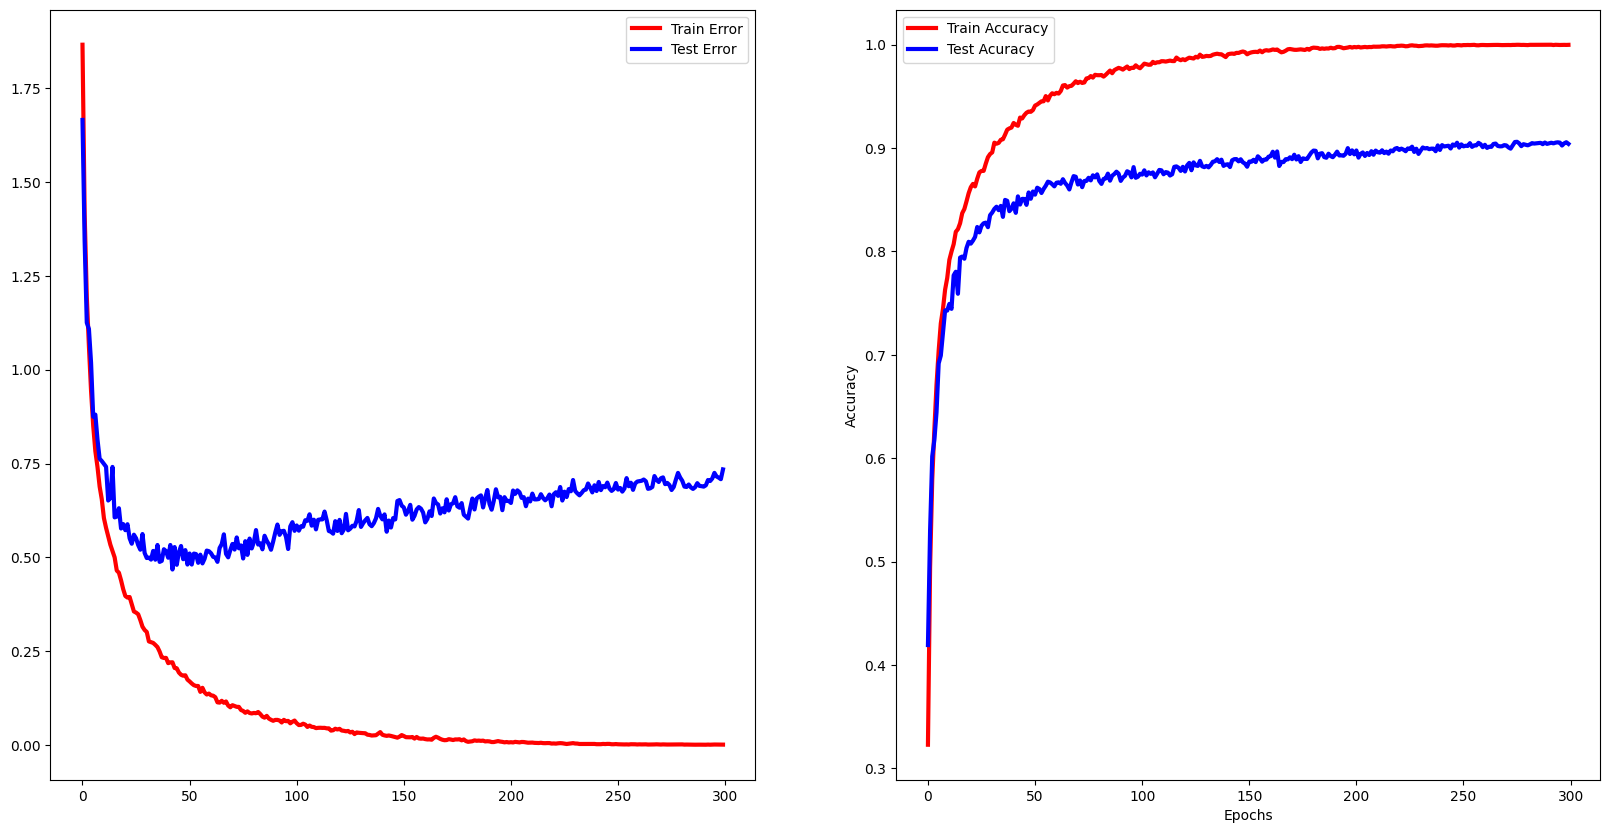

In [10]:
figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
n = len(trainingLoss)
ax1.plot(range(n), trainingLoss, '-', linewidth='3', label='Train Error',color='Red')
ax1.plot(range(n), testingLoss, '-', linewidth='3', label='Test Error',color='Blue')

ax2.plot(range(n), trainingAccuracy, '-', linewidth='3', label='Train Accuracy',color='Red')
ax2.plot(range(n), testingAccuracy, '-', linewidth='3', label='Test Acuracy',color='Blue')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')

ax1.legend()
ax2.legend()
figure.savefig("./trainTestCurve.png")

In [11]:
corrects = 0.0
for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    output = model(images)
    output = torch.argmax(output, dim=1)
    corrects += torch.sum(labels == output).float().item()
print(corrects/len(test_loader.dataset))

0.904


In [12]:
!pip install onnx
model = resnet_model()
model.load_state_dict(torch.load('./saved_model.pt'))
# set the model to evaluation mode 
model.eval() 

# Let's create a sample input tensor  
x = torch.randn(4, 3, 32, 32)

torch.onnx.export(model, x, "final_resnet_model.onnx", opset_version = 11)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 89.4 MB/s eta 0:00:00


Model Config: 
-------------------------------------
N (# Layers)	: 4 
B (# Blocks)	: [3, 3, 2, 3] 
C (# Channels)	: [64, 128, 128, 256] 
F (Conv Kernel)	: [3, 3, 3, 3] 
K (Skip Kernel)	: [1, 1, 1, 1] 
P (Pool Kernel)	: 4
============= Diagnostic Run torch.onnx.export version 2.0.0+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

============= Diagnostic Run torch.onnx.export version 2.0.0+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

